* Image Encoder extracts visual features from images. Arch: vision transformer in CLIP. 

* Vision-Language Projector changes dimensionality of image features, so that it matches text embeddings. So image features become ‘visual tokens’ for the decoder. 

* A decoder only language model, ultimately generates text.

In [1]:
import base64
import io
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import init

In [2]:
# Ensure every computation happens on the GPU when available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Generate tokens using the tiny_shakespeare dataset
text_path = "./input.txt"
with open(text_path, 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
stoi['<pad>']= 65
itos = { i:ch for i,ch in enumerate(chars) }
itos[65] = '<pad>'
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
vocab_size = len(stoi.keys())

PatchEmbeddings class takes image and creates sequence of patches. Used for efficient attention.

In [4]:
class PatchEmbeddings(nn.Module):
    def __init__(self, img_size=96, patch_size=16, hidden_dim=512):
        super().__init__()

        # input image size
        self.img_size = img_size

        # size of each patch
        self.patch_size = patch_size

        # total number of patches
        self.num_patches = (img_size // patch_size) ** 2

        # convolutional layer to extract patch embeddings
        # in_channels=3 assumes RGB
        # kernel_size=patch_size and stride=patch_size ensure each patch is separately embedded
        self.conv = nn.Conv2d(in_channels=3, out_channels=hidden_dim,
                              kernel_size=patch_size, stride=patch_size)

    def forward(self, X):
        # Extract patch embeddings from input image
        X = self.conv(X)

        # Flatten spatial dimensions (height and width) of the patch embeddings into 1D
        X = X.flatten(2)

        # Transpose the dimensions into [batch_size, num_patches, hidden_dim]
        # This step brings the num_patches dimension to the second position
        X = X.transpose(1, 2)

        return X


In [5]:
#testing
img_size, patch_size,  num_hiddens, batch_size = 96, 16, 512, 4
patch_embeddings = PatchEmbeddings(img_size, patch_size, num_hiddens )
X = torch.zeros(batch_size, 3, img_size, img_size)
patch_embeddings(X).shape

torch.Size([4, 36, 512])

GELU seen used quite often in Vision Transformers; ReLU used in text transformers. MLP switches between them.


In [6]:
class MLP(nn.Module):
    def __init__(self, n_embd, dropout=0.1, is_decoder=True):
        super().__init__()

        # Define the layers of the MLP
        layers = [
            # First linear layer that expands the input dimension 4x
            nn.Linear(n_embd, 4 * n_embd),

            # Activation function: ReLU if is_decoder is True, else GELU
            nn.ReLU() if is_decoder else nn.GELU(),

            # Second linear layer that projects the intermediate dimension back to n_embd
            nn.Linear(4 * n_embd, n_embd),

            # Dropout layer for regularization
            nn.Dropout(dropout)
        ]

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [7]:
#For the sake of this example consider embedding size to be 128
n_embd = 128
testmlp = MLP(n_embd)
mlp_input = torch.zeros(batch_size, 3, n_embd)
testmlp_out = testmlp(mlp_input)
testmlp_out.shape

torch.Size([4, 3, 128])

In [8]:
class Head(nn.Module):
    def __init__(self, n_embd, head_size, dropout=0.1, is_decoder=False):
        super().__init__()

        # Linear layer for key projection
        self.key = nn.Linear(n_embd, head_size, bias=False)

        # Linear layer for query projection
        self.query = nn.Linear(n_embd, head_size, bias=False)

        # Linear layer for value projection
        self.value = nn.Linear(n_embd, head_size, bias=False)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

        # Flag indicating whether this head is used in the decoder
        self.is_decoder = is_decoder

    def forward(self, x):
        # Get the batch size (B), sequence length (T), and embedding dimension (C) from the input tensor
        B, T, C = x.shape

        # Compute key, query, and value projections
        k = self.key(x)   # Shape: [B, T, head_size]
        q = self.query(x) # Shape: [B, T, head_size]

        v = self.value(x) # Shape: [B, T, head_size]

        # Compute attention scores by taking the dot product of query and key
        # and scaling by the square root of the embedding dimension
        wei = q @ k.transpose(-2, -1) * (C ** -0.5) # Shape: [B, T, T]

        if self.is_decoder:
            # If this head is used in the decoder, apply a causal mask to the attention scores
            # to prevent attending to future positions
            tril = torch.tril(torch.ones(T, T, dtype=torch.bool, device=x.device))
            wei = wei.masked_fill(tril == 0, float('-inf'))

        # Apply softmax to the attention scores to obtain attention probabilities
        wei = F.softmax(wei, dim=-1) # Shape: [B, T, T]

        # Apply dropout to the attention probabilities for regularization
        wei = self.dropout(wei)

        # Perform weighted aggregation of values using the attention probabilities
        out = wei @ v # Shape: [B, T, head_size]

        return out


In [9]:
#Example values for testing
n_embd, head_size, batch_size = 128, 16, 4

testhead = Head(n_embd, head_size)
head_input = torch.zeros(batch_size, 3, n_embd)
testhead_out = testhead(head_input)
testhead_out.shape # (B, T,H_size)

torch.Size([4, 3, 16])

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.1, is_decoder=False):
        super().__init__()

        # Ensure that the embedding dimension is divisible by the number of heads
        assert n_embd % num_heads == 0, "n_embd must be divisible by num_heads"

        # Create a ModuleList of attention heads
        self.heads = nn.ModuleList([
            Head(n_embd, n_embd // num_heads, dropout, is_decoder)
            for _ in range(num_heads)
        ])

        # Linear layer for projecting the concatenated head outputs
        self.proj = nn.Linear(n_embd, n_embd)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Apply each attention head to the input tensor
        head_outputs = [h(x) for h in self.heads]

        # Concatenate the outputs from all heads along the last dimension
        out = torch.cat(head_outputs, dim=-1)

        # Apply the projection layer to the concatenated outputs
        out = self.proj(out)

        # Apply dropout to the projected outputs for regularization
        out = self.dropout(out)

        return out


In [11]:
#Example values for testing
n_embd, n_head = 128, 8
testmha = MultiHeadAttention(n_embd, n_head)
head_input = torch.zeros(batch_size, 3, n_embd)
testmha_out = testmha(head_input)
testmha_out.shape # (B, T,H_size*n_heads = n_embed)

torch.Size([4, 3, 128])

Each encoder transformer block looks as follows

In [12]:
class Block(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.1, is_decoder=False):
        super().__init__()

        # Layer normalization for the input to the attention layer
        self.ln1 = nn.LayerNorm(n_embd)

        # Multi-head attention module
        self.attn = MultiHeadAttention(n_embd, num_heads, dropout, is_decoder)

        # Layer normalization for the input to the FFN
        self.ln2 = nn.LayerNorm(n_embd)

        # Feed-forward neural network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # Expand the dimension
            nn.GELU(),  # Activation function
            nn.Linear(4 * n_embd, n_embd),  # Project back to the original dimension
        )

    def forward(self, x):
        original_x = x  # Save the input for the residual connection

        # Apply layer normalization to the input
        x = self.ln1(x)

        # Apply multi-head attention
        attn_output = self.attn(x)

        # Add the residual connection (original input) to the attention output
        x = original_x + attn_output

        # Apply layer normalization to the input to the FFN
        x = self.ln2(x)

        # Apply the FFN
        ffn_output = self.ffn(x)

        # Add the residual connection (input to FFN) to the FFN output
        x = x + ffn_output

        return x

In [13]:
#Example values for testing
n_embd, head_size, batch_size = 128, 16, 4

testblock = Block(n_embd, n_head)
block_input = torch.zeros(batch_size, 3, n_embd)
testblock_out = testblock(block_input)
testblock_out.shape

torch.Size([4, 3, 128])

Now all this can be be put together to implement a Vision Transformer

In [14]:
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()

        # Patch embedding layer to convert the input image into patches
        self.patch_embedding = PatchEmbeddings(img_size, patch_size, num_hiddens)

        # Learnable classification token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))

        # Calculate the number of patches
        num_patches = (img_size // patch_size) ** 2

        # Learnable position embedding
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, num_hiddens))

        # Dropout layer for the embeddings
        self.dropout = nn.Dropout(emb_dropout)

        # Stack of transformer blocks
        self.blocks = nn.ModuleList([Block(num_hiddens, num_heads, blk_dropout, is_decoder=False) for _ in range(num_blks)])

        # Layer normalization for the final representation
        self.layer_norm = nn.LayerNorm(num_hiddens)

    def forward(self, X):
        # Convert the input image into patch embeddings
        x = self.patch_embedding(X)

        # Expand the classification token to match the batch size
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)

        # Concatenate the classification token with the patch embeddings
        x = torch.cat((cls_tokens, x), dim=1)

        # Add the position embedding to the patch embeddings
        x += self.pos_embedding

        # Apply dropout to the embeddings
        x = self.dropout(x)

        # Pass the embeddings through the transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply layer normalization to the final representation
        x = self.layer_norm(x[:, 0])

        return x


In [15]:
#For purposes of testing
img_size, patch_size, num_hiddens, n_head, num_blks, dropout = 96, 16, 512, 8, 3, 0.1

testvit = ViT(img_size, patch_size, num_hiddens, n_head, num_blks, dropout, dropout)
vit_input = torch.zeros(batch_size, 3, img_size, img_size)
testvit_out = testvit(vit_input)
testvit_out.shape

torch.Size([4, 512])

Vision-Language projector to adapt latent space (image -> text embeddings).

Current trend is: keep both vision encoder and language decoder frozen during the VLM training phase.
So more parameters can go to the projector and maybe improve quality

In [16]:
class MultiModalProjector(nn.Module):
    def __init__(self, n_embd, image_embed_dim, dropout=0.1):
        super().__init__()

        # Define the projection network
        self.net = nn.Sequential(
            # Linear layer to expand the image embedding dimension
            nn.Linear(image_embed_dim, 4 * image_embed_dim),

            # GELU activation function
            nn.GELU(),

            # Linear layer to project the expanded image embeddings to the text embedding dimension
            nn.Linear(4 * image_embed_dim, n_embd),

            # Dropout layer for regularization
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Pass the input through the projection network
        x = self.net(x)
        return x


In [17]:
#Example values for testing
n_embd,num_hiddens = 128, 512

testmmp = MultiModalProjector(n_embd,num_hiddens)
mmp_input = testvit_out
testmmp_out = testmmp(mmp_input)
testmmp_out.shape

torch.Size([4, 128])

Essentially the text generation is conditioned on the initial image input. This can be modified in a number of ways to work with interleaved text and images, which will be useful for multi-turn conversation i.e. chat scenarios using the finetuned VLM.

In [18]:
class DecoderLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=False):
        super().__init__()

        self.use_images = use_images

        # Token embedding table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)

        # Position embedding table
        self.position_embedding_table = nn.Embedding(1000, n_embd)

        if use_images:
            # Image projection layer to align image embeddings with text embeddings
            self.image_projection = MultiModalProjector(n_embd, image_embed_dim)

        # Stack of transformer decoder blocks
        self.blocks = nn.Sequential(*[Block(n_embd, num_heads, is_decoder=True) for _ in range(n_layer)])

        # Final layer normalization
        self.ln_f = nn.LayerNorm(n_embd)

        # Language modeling head
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, image_embeds=None, targets=None):
        # Get token embeddings from the input indices
        tok_emb = self.token_embedding_table(idx)

        if self.use_images and image_embeds is not None:
            # Project and concatenate image embeddings with token embeddings
            img_emb = self.image_projection(image_embeds).unsqueeze(1)
            tok_emb = torch.cat([img_emb, tok_emb], dim=1)

        # Get position embeddings
        pos_emb = self.position_embedding_table(torch.arange(tok_emb.size(1), device=device)).unsqueeze(0)

        # Add position embeddings to token embeddings
        x = tok_emb + pos_emb

        # Pass through the transformer decoder blocks
        x = self.blocks(x)

        # Apply final layer normalization
        x = self.ln_f(x)

        # Get the logits from the language modeling head
        logits = self.lm_head(x)

        if targets is not None:
            if self.use_images and image_embeds is not None:
                # Prepare targets by concatenating a dummy target for the image embedding
                batch_size = idx.size(0)
                targets = torch.cat([torch.full((batch_size, 1), -100, dtype=torch.long, device=device), targets], dim=1)

            # Compute the cross-entropy loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-100)
            return logits, loss

        return logits

    def generate(self, idx, image_embeds, max_new_tokens):
        # Get the batch size and sequence length
        B, T = idx.shape

        # Initialize the generated sequence with the input indices
        generated = idx

        if self.use_images and image_embeds is not None:
            # Project and concatenate image embeddings with token embeddings
            img_emb = self.image_projection(image_embeds).unsqueeze(1)
            current_output = torch.cat([img_emb, self.token_embedding_table(idx)], dim=1)
        else:
            current_output = self.token_embedding_table(idx)

        # Generate new tokens iteratively
        for i in range(max_new_tokens):
            # Get the current sequence length
            T_current = current_output.size(1)

            # Get position embeddings for the current sequence length
            current_pos_emb = self.position_embedding_table(torch.arange(T_current, device=device)).unsqueeze(0)

            # Add position embeddings to the current output
            current_output += current_pos_emb

            # Pass through the transformer decoder blocks
            for block in self.blocks:
                current_output = block(current_output)

            # Get the logits for the last token
            logits = self.lm_head(current_output[:, -1, :])

            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)

            # Sample the next token based on the probabilities
            idx_next = torch.multinomial(probs, num_samples=1)

            # Concatenate the generated token to the generated sequence
            generated = torch.cat((generated, idx_next), dim=1)

            # Get the embeddings for the generated token
            idx_next_emb = self.token_embedding_table(idx_next)

            # Concatenate the generated token embeddings to the current output
            current_output = torch.cat((current_output, idx_next_emb), dim=1)

        return generated

In [19]:
model = DecoderLanguageModel(n_embd=128, image_embed_dim=256, vocab_size=1000, num_heads=8, n_layer=6, use_images=True)
model.to(device)
# Dummy input
B, T = 10, 50
idx = torch.randint(0, 1000, (B, T)).to(device)
image_embeds = torch.randn(B, 256).to(device)  # Assume image_embed_dim is 256

targets = torch.randint(0, vocab_size, (B, T)).to(device)  # Only if you want to compute loss

# Test forward pass
# Check if you need to calculate loss by providing targets
if targets is not None:
    logits, loss = model(idx, image_embeds, targets)
    print(f"Logits shape: {logits.shape}, Loss: {loss}")
else:
    logits = model(idx, image_embeds)  # Call without targets
    print(f"Logits shape: {logits.shape}")

# Test generation
generated = model.generate(idx, image_embeds, max_new_tokens=20)
print(f"Generated sequence shape: {generated.shape}")



Logits shape: torch.Size([10, 51, 1000]), Loss: 7.129022598266602
Generated sequence shape: torch.Size([10, 70])


Combining components into a VLM:

1. Get features from the vision encoder (could be any model that generates features from an image input such as a ResNet or a CNN (needless to say performance may suffer))

2. Project features to text token space

3. A decoder language model for generating text conditioned on a preceding image.


In [20]:
class VisionLanguageModel(nn.Module):
    def __init__(self, n_embd, image_embed_dim, vocab_size, n_layer, img_size, patch_size, num_heads, num_blks, emb_dropout, blk_dropout):
        super().__init__()

        # Set num_hiddens equal to image_embed_dim
        num_hiddens = image_embed_dim

        # Assert that num_hiddens is divisible by num_heads
        assert num_hiddens % num_heads == 0, "num_hiddens must be divisible by num_heads"

        # Initialize the vision encoder (ViT)
        self.vision_encoder = ViT(img_size, patch_size, num_hiddens, num_heads, num_blks, emb_dropout, blk_dropout)

        # Initialize the language model decoder (DecoderLanguageModel)
        self.decoder = DecoderLanguageModel(n_embd, image_embed_dim, vocab_size, num_heads, n_layer, use_images=True)

    def forward(self, img_array, idx, targets=None):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        if targets is not None:
            # If targets are provided, compute the logits and loss
            logits, loss = self.decoder(idx, image_embeds, targets)
            return logits, loss
        else:
            # If targets are not provided, compute only the logits
            logits = self.decoder(idx, image_embeds)
            return logits

    def generate(self, img_array, idx, max_new_tokens):
        # Get the image embeddings from the vision encoder
        image_embeds = self.vision_encoder(img_array)

        # Check if the image embeddings are valid
        if image_embeds.nelement() == 0 or image_embeds.shape[1] == 0:
            raise ValueError("Something is wrong with the ViT model. It's returning an empty tensor or the embedding dimension is empty.")

        # Generate new tokens using the language model decoder
        generated_tokens = self.decoder.generate(idx, image_embeds, max_new_tokens)
        return generated_tokens

In [21]:
image_embed_dim = num_hiddens

In [22]:
n_layer, block_size =  8, 32

# Initialize the model
model = VisionLanguageModel(n_embd, image_embed_dim, vocab_size,  n_layer, img_size, patch_size, n_head, num_blks, dropout, dropout)
model.to(device)

# Create dummy data with correct dimensions
dummy_img = torch.randn(1, 3, img_size, img_size).to(device)  # Correct shape for image input
dummy_idx = torch.randint(0, vocab_size, (1, block_size)).to(device)  # Correct shape for text input

# Forward pass to initialize all parameters
try:
    output = model(dummy_img, dummy_idx)  # Output for debugging
    print("Output from initialization forward pass:", output)
except RuntimeError as e:
    print(f"Runtime Error during forward pass: {str(e)}")
    print("Check layer configurations and input shapes.")

Output from initialization forward pass: tensor([[[-0.0972, -0.2284,  0.1095,  ...,  0.0540, -0.6659,  0.0382],
         [-0.1683,  0.3727,  1.3922,  ...,  0.5167, -0.1858, -0.2209],
         [-0.1086, -0.2854, -0.0641,  ..., -0.3695,  0.1651,  0.5632],
         ...,
         [-0.0239, -0.5123,  0.4492,  ..., -0.0520,  0.1523, -0.6354],
         [ 0.6563,  0.3353, -0.2636,  ...,  0.5350, -0.0443,  0.4575],
         [-0.7029, -0.4081,  0.9005,  ...,  0.6405, -0.9829, -0.0148]]],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [23]:
# convert images
def base64_to_tensor(base64_str, img_size=96):
    image = Image.open(io.BytesIO(base64.b64decode(base64_str)))
    if image.mode != 'RGB':
        image = image.convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

In [24]:
#Adjusting the data loader from makemore for multimodal data
def get_batch(df, batch_size, split='train', img_size=96, val_batch_size=8):
    # Split data into training and validation sets
    n = int(0.9 * len(df))  # first 90% will be train, rest val
    df_train = df.iloc[:n]
    df_val = df.iloc[n:]
    data = df_train if split == 'train' else df_val
    batch_size = batch_size if split == 'train' else val_batch_size
    replace = False if split == 'train' else True
    batch = data.sample(n=batch_size, replace=replace)

    images = torch.cat([base64_to_tensor(img, img_size) for img in batch['b64string_images']], dim=0).to(device)
    text_indices = [torch.tensor(encode(desc), dtype=torch.long) for desc in batch['caption']]
    max_length = max(len(t) for t in text_indices)

    padded_text = torch.full((batch_size, max_length), fill_value=stoi['<pad>'], dtype=torch.long).to(device)
    for i, text in enumerate(text_indices):
        padded_text[i, :len(text)] = text

    targets = torch.cat([padded_text[:, 1:], torch.full((batch_size, 1), fill_value=stoi['<pad>'], dtype=torch.long, device=device)], dim=1)

    # Truncate or pad targets to match the length of padded_text
    if targets.size(1) > padded_text.size(1):
        targets = targets[:, :padded_text.size(1)]
    elif targets.size(1) < padded_text.size(1):
        targets = torch.cat([targets, torch.full((batch_size, padded_text.size(1) - targets.size(1)), fill_value=stoi['<pad>'], dtype=torch.long, device=device)], dim=1)

    return images, padded_text, targets

In [25]:
#Adjusting the training loop from makemore for multimodal data
def train_model(model, df, epochs, vocab_size, img_size=96):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for _ in range(max_iters):
            images, idx, targets = get_batch(df, batch_size, 'train', img_size)
            optimizer.zero_grad()
            logits, loss = model(images, idx, targets)
            loss.backward()
            optimizer.step()
            if _ % eval_interval == 0:
                print(f"Loss at iteration {_}: {loss.item()}")
        val_loss = estimate_loss(model, df, 'val', img_size, val_batch_size=8)
        print(f"Validation Loss after epoch {epoch}: {val_loss}")

def estimate_loss(model, df, split, img_size=96, val_batch_size=8):
    losses = []
    model.eval()
    for _ in range(eval_iters):
        images, idx, targets = get_batch(df, batch_size, split, img_size, val_batch_size=val_batch_size)
        _, loss = model(images, idx, targets)
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [26]:
df = pd.read_csv("./inputs.csv")
#Expanding dataframe so that there's enough data to test. This is just duplicating data. A real dataset would have more rows
df = pd.concat([df] * 30)[['b64string_images', 'caption']]
df.shape

(90, 2)

In [27]:
# display(df.head())

In [28]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 100
eval_interval = 10
learning_rate = 1e-3
epochs=1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 40
num_blks= 3
head_size = 16
n_embd = 128
n_head = 8
n_layer = 8
dropout = 0.1
img_size=96
patch_size =16
image_embed_dim = 512
emb_dropout = blk_dropout =0.1

In [29]:
# Initialize the model
model = VisionLanguageModel(n_embd, image_embed_dim, vocab_size, n_layer, img_size, patch_size, n_head, num_blks, emb_dropout, blk_dropout)
model.to(device)

# Dummy data to initialize lazy modules
dummy_img = torch.randn(1, 3, img_size, img_size).to(device)
dummy_idx = torch.randint(0, vocab_size, (1, block_size)).to(device)
model(dummy_img, dummy_idx)  # Forward pass to initialize all parameters

# Train the model
train_model(model, df, epochs, vocab_size, img_size)


Loss at iteration 0: 4.303333282470703
Loss at iteration 10: 0.4161747694015503
Loss at iteration 20: 0.08638541400432587
Loss at iteration 30: 0.033552736043930054
Loss at iteration 40: 0.018074892461299896
Loss at iteration 50: 0.012394454330205917
Loss at iteration 60: 0.009890234097838402
Loss at iteration 70: 0.008215047419071198
Loss at iteration 80: 0.007281459867954254
Loss at iteration 90: 0.006457779556512833
Validation Loss after epoch 0: 0.0056888546328991655


In [30]:
images, idx, targets = get_batch(df, batch_size, 'train', img_size)
images.shape, idx.shape, targets.shape

(torch.Size([16, 3, 96, 96]), torch.Size([16, 32]), torch.Size([16, 32]))

In [31]:
_ = model.eval()

In [32]:
from IPython.display import display

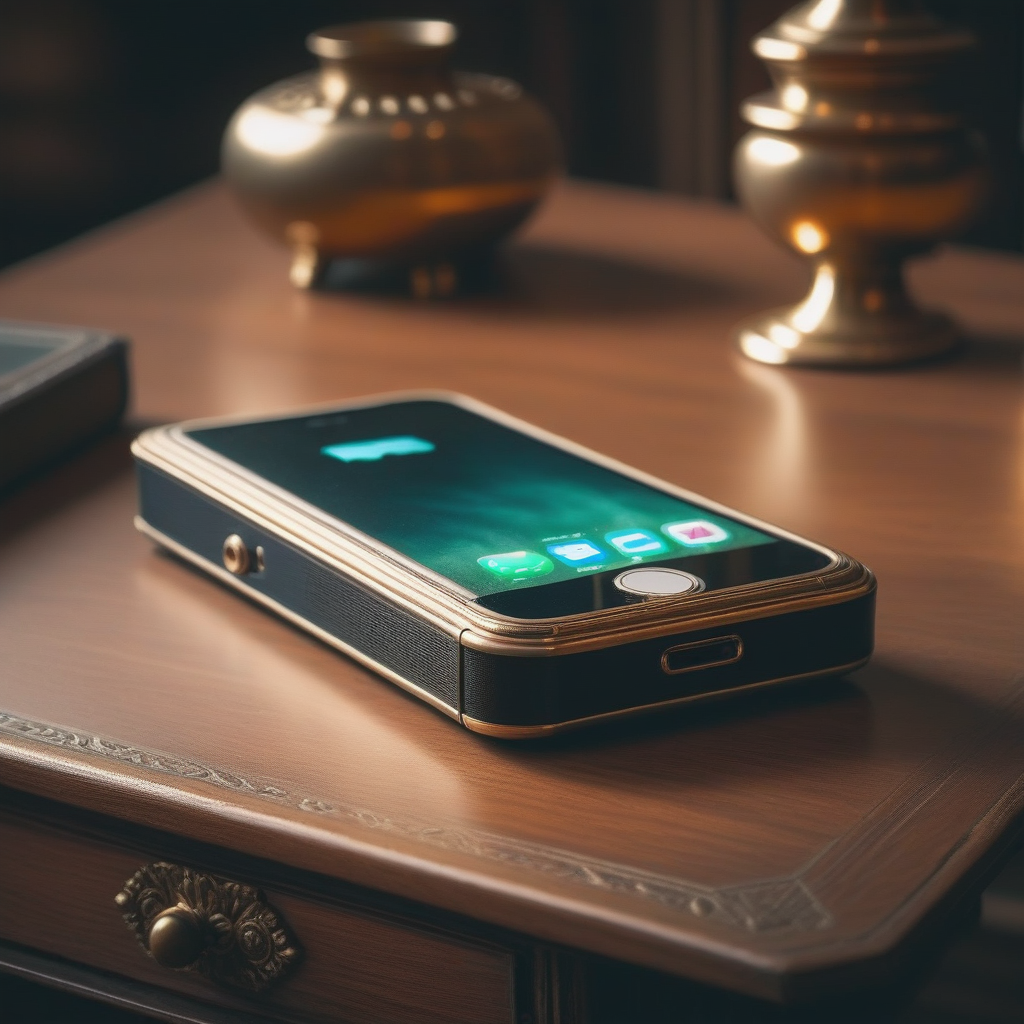

an antique iphone on a table


In [33]:
idx = 1
img = df["b64string_images"].iloc[idx]
cap = df["caption"].iloc[idx]

image = Image.open(io.BytesIO(base64.b64decode(img)))
if image.mode != 'RGB':
    image = image.convert('RGB')
#image = image.resize((96,96))
display(image)
print(cap)

In [34]:
def encode_text(s: str):
    inpt_enc = torch.tensor(encode(s)).unsqueeze(0)
    return inpt_enc

In [35]:
def generate(img, text, max_tokens):
    text = encode_text(text).to(device)
    img = base64_to_tensor(img).to(device)
    output = model.generate(img, text, max_tokens)
    line = [int(i) for i in output[0]]
    return decode(line)

In [36]:
generate(img, "iphone", 30)

'iphoneique iphone on a table<pad><pad><pad><pad><pad><pad><pad><pad>'